**FYP Google Colab Code Collection:**

This first set of cells will cover declaring all import libaries and mounting the google drive.

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

#Declaring Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import pickle
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
from numpy import save
import torch.nn.functional as F
import time
import statistics
import math
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

#Setting Up the GPU/CPU
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else "cpu")
print("cuda or cpu?:", device)
torch.cuda.empty_cache()
plt.style.use('default')

Mounted at /content/gdrive
cuda or cpu?: cuda:0


Declaring Misc Functions

In [2]:
### Declaring Functions and Classes ###

#Function to Load Datafiles
def Load_data(filenameData, filenameLabel): 
    X_source = np.load(filenameData, allow_pickle=True)
    Y_source = np.load(filenameLabel, allow_pickle=True)
    
    return X_source, Y_source 

#Function to Randomize Data    
def Randomize_data(X_source, Y_source):
    randomize = np.arange(len(Y_source))
    np.random.shuffle(randomize)
    np.random.shuffle(randomize)
    randomize = np.expand_dims(randomize, axis=1)

    X_source = X_source[randomize]
    Y_source = Y_source[randomize]
    
    X_source = np.squeeze(X_source)
    Y_source = np.squeeze(Y_source)
    Y_source = np.expand_dims(Y_source, axis = 1)
    
    return X_source, Y_source

#Function to Define Label Encoding
def Define_LabelEncoder(Y_source):
    le = preprocessing.LabelEncoder()
    le.fit(Y_source)
    
    return le

#Function to Encode Labels    
def Encode_Labels(le, Y_source):
    Y_source = le.transform(Y_source)
    Y_source = np.expand_dims(Y_source, axis=1)
    
    return Y_source

#Function to convert array into CNN dimensions    
def CNN_Dimension_Convert(X_source, Y_source):
    X_source = X_source[:, 3:243]
    X_source = np.expand_dims(X_source, axis=1)
    Y_source = np.expand_dims(Y_source, axis=1)
    
    return X_source, Y_source

#Function to convert Data and Labels into Tensors    
def Tensor_Convert(X_source, Y_source):
    X_source = torch.from_numpy(X_source).float()#.to(device)
    Y_source = torch.from_numpy(Y_source).float()#.to(device)

    return X_source, Y_source

#Function to perform data standardization
def Standardize_Data (X_source):

    std_array = np.std(X_source, axis = 1)
    std_array = np.expand_dims(std_array, axis=1)
    mean_array = np.mean(X_source, axis = 1)
    mean_array = np.expand_dims(mean_array, axis=1)
    New_array = np.subtract(X_source, mean_array)
    New_array = np.divide(New_array, std_array)

    return New_array

#Function to Perform MinMax Scaling
def MinMaxCreate (X_source):

    scaler = MinMaxScaler()
    New_array = scaler.fit_transform(X_source.T)
    return New_array.T

#Function to Perform MaxAbs Scaling
def MaxAbsCreate (X_source):

    scaler = MaxAbsScaler()
    New_array = scaler.fit_transform(X_source.T)
    return New_array.T

#Function to Perform Robust Scaling
def RobustCreate (X_source):

    scaler = RobustScaler()
    New_array = scaler.fit_transform(X_source.T)
    return New_array.T

#Function to Perform Quantile Scaling
def QuantileCreate (X_source):

    scaler = QuantileTransformer()
    New_array = scaler.fit_transform(X_source.T)
    return New_array.T

#Function to Perform Power (via YJ method) Scaling
def PowerCreate (X_source):

    scaler = PowerTransformer(method = 'yeo-johnson')
    New_array = scaler.fit_transform(X_source.T)
    return New_array.T

#Function which takes a spectra, splits it into 5, puts through a model and votes the max value as the desired value
#This was to perform Window Slicing
#NOTE: NOT IN USE BY THE ACTIVE CODE
#NOTE: NOT INCLUDED WITHIN THE REPORT/RESULTS
def TestDataSplit (X_source, model):
  S = 5

  Store_Array = []

  for i in range(X_source.shape[0]):
    Split_Array = []
    Desired_Spectra = X_source[i, :]
    for j in range(S):
      L = (((j*240)/S))
      U = ((((j+1)*240)/S))
      L = int(L)
      U = int(U)
      Split_Spectra = Desired_Spectra[0, L:U]
      Split_Spectra = np.expand_dims(Split_Spectra, axis = 0)
      Split_Spectra = np.expand_dims(Split_Spectra, axis = 0)
      Split_Spectra = torch.from_numpy(Split_Spectra).float()
    
      Check = CNN_Model(Split_Spectra)
      Check = Check.detach().numpy()
      Check = np.squeeze(Check)
      Check = np.argmax(Check)
      Split_Array.append(Check)
    Split_Array = np.asarray(Split_Array)
    counts = np.bincount(Split_Array)
    send_value = np.argmax(counts)
    Store_Array.append(send_value)

  Store_Array = np.asarray(Store_Array)
  Check = Store_Array

  return Check

Declaring 1D U-NET NN Function:

In [3]:
#Defining the 1D U-NET
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=5,bias=False):
        block = torch.nn.Sequential(
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=2,bias=False),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm1d(out_channels),
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=2,bias=False),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm1d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=5):
            block = torch.nn.Sequential(
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=2,bias=False),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm1d(mid_channel),
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=2,bias=False),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm1d(mid_channel),
                    torch.nn.ConvTranspose1d(in_channels=mid_channel, out_channels=out_channels, kernel_size=4, stride=2, padding=1,bias=False)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=5):
            block = torch.nn.Sequential(
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=2,bias=False),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm1d(mid_channel),
                    torch.nn.Conv1d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=2,bias=False),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm1d(mid_channel),
                    )
            return  block
            
    def bottleneck(self, in_channels, out_channels, kernel_size = 5):
        block = torch.nn.Sequential(
                torch.nn.Conv1d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=2,bias=False),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(out_channels),
                torch.nn.Conv1d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=2,bias=False),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(out_channels),
                torch.nn.ConvTranspose1d(in_channels=out_channels, out_channels=in_channels, kernel_size=4, stride=2, padding=1,bias=False),
                )
        return  block
   
    def finish_layer(self, MidPerceptron, Dropout):
        block = torch.nn.Sequential(
                torch.nn.Dropout(Dropout),
                torch.nn.Linear(64*240, MidPerceptron),
                torch.nn.Linear(MidPerceptron, 30), 
                torch.nn.ReLU(),
                )
        return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(in_channels=64, out_channels=128)
        self.conv_maxpool2 = torch.nn.MaxPool1d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(in_channels=128, out_channels=256)
        self.conv_maxpool3 = torch.nn.MaxPool1d(kernel_size=2)
        
        # Bottleneck
        self.bottleneck1 = self.bottleneck(in_channels=256, out_channels=512)
        
        # Decode
        self.conv_decode1 = self.expansive_block(in_channels = 512, mid_channel = 256, out_channels = 128)
        self.conv_decode2 = self.expansive_block(in_channels = 256, mid_channel = 128, out_channels = 64)
        self.final_layer1 = self.final_block(128, 64, out_channel)
        
        #Final Layer
        self.hidden1 = nn.Linear(64*240, 128)
        self.dout1 = nn.Dropout(0.80)
        self.hidden2 = nn.Linear(128, 30)
        self.relu1 = nn.ReLU()
        
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            cut = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-cut, -cut))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)

        # Bottleneck
        bottleneck_block1 = self.bottleneck1(encode_pool3)

        # Decode
        decode_block1 = self.crop_and_concat(bottleneck_block1, encode_block3, crop=True)
        decode_prop1 = self.conv_decode1(decode_block1)
        decode_block2 = self.crop_and_concat(decode_prop1, encode_block2, crop=True)
        decode_prop2 = self.conv_decode2(decode_block2)
        decode_block3 = self.crop_and_concat(decode_prop2, encode_block1, crop=True)
        final_layer_block = self.final_layer1(decode_block3)
        
        #Making Into Final Layer and Unfolding
        final_layer_block = final_layer_block.view(final_layer_block.size(0), -1) 
        final_layer = self.dout1(final_layer_block)
        final_layer = self.hidden1(final_layer)
        final_layer = self.relu1(final_layer)
        final_layer = self.dout1(final_layer)
        final_layer = self.hidden2(final_layer)
        return  final_layer
        

Declaring the Shallow ResNet Block

In [4]:
class ResBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=15,padding=7,bias=False):
        super(ResBlock,self).__init__()
        self.b1 =nn.Sequential(
            nn.Conv1d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv1d(out_channels,out_channels,kernel_size,1,padding,bias=False),
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
            )
        else:
            self.shortcut = nn.Sequential()
        self.Bnorm1 = nn.BatchNorm1d(out_channels)
            
    def forward(self,x):
        residual = x
        x = self.b1(x)
        x = self.b2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        x = self.Bnorm1(x)
        return x

Declaring the Deep ResNet Block

In [5]:
class ResBlock2(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=7,padding=3,bias=False):
        super(ResBlock2,self).__init__()
        self.b1 =nn.Sequential(
            nn.Conv1d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.b2 =nn.Sequential(
            nn.Conv1d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.b3 =nn.Sequential(
            nn.Conv1d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.b4 =nn.Sequential(
            nn.Conv1d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.b5 =nn.Sequential(
            nn.Conv1d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.b6 = nn.Sequential(
            nn.Conv1d(out_channels,out_channels,kernel_size,1,padding,bias=False),
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
            )
        else:
            self.shortcut = nn.Sequential()
        self.Bnorm1 = nn.BatchNorm1d(out_channels)
            
    def forward(self,x):
        residual = x
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.b6(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        x = self.Bnorm1(x)
        return x

Creating the Deep ResNet Model

In [6]:
class ResNetModelDeep(nn.Module):
    def __init__(self):
        super(ResNetModelDeep,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv1d(1,64,kernel_size=15,stride=2,padding=7,bias=False),
            nn.ReLU(True),
            nn.BatchNorm1d(64)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool1d(2),
            ResBlock2(64,64)
        )
        
        self.block3 = nn.Sequential(
            ResBlock2(64,128, 2)
        )
        
        self.block4 = nn.Sequential(
            ResBlock2(128,256, 2)
        )
        
        self.avgpool = nn.AvgPool1d(15)
        self.fc1 = nn.Linear(256,30)
        self.dout1 = nn.Dropout(0.8) 
        self.hidden1 = nn.Linear(15*256, 128)
        self.hidden2 = nn.Linear(128, 30)
        self.relu1 = nn.ReLU()

        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        #Using Avg Pool
        #x = self.avgpool(x)
        #x1 = self.dout1(x1)
        #x1 = self.fc1(x)


        #Sep here
        x = x.view(x.size(0),-1)
        x = self.dout1(x)
        x1 = self.hidden1(x)
        x1 = self.relu1(x1)
        x1 = self.dout1(x1)
        x1 = self.hidden2(x1)

        return x1

Creating the Shallow ResNet Model

In [7]:
class ResNetModelShallow(nn.Module):
    def __init__(self):
        super(ResNetModelShallow,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv1d(1,64,kernel_size=21,stride=2,padding=10,bias=False),
            nn.ReLU(True),
            nn.BatchNorm1d(64)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool1d(2),
            ResBlock(64,64),
            ResBlock(64,64),
            ResBlock(64,64) 
        )
        
        self.block3 = nn.Sequential(
            #ResBlock(64,128, 2),
            #ResBlock(128,128),
            #ResBlock(128,128)
        )
        
        self.block4 = nn.Sequential(
            #ResBlock(128,256, 2),
            #ResBlock(256,256),
            #ResBlock(256,256)
        )
        
        self.avgpool = nn.AvgPool1d(15)
        self.fc1 = nn.Linear(256,30)
        self.dout1 = nn.Dropout(0.8) 
        self.hidden1 = nn.Linear(15*256, 128)
        self.hidden2 = nn.Linear(128, 30) 
        self.relu1 = nn.ReLU()

        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        #x = self.block3(x) #Not using but kept for easy implimentation
        #x = self.block4(x) #Not using but kept for easy implimentation

        #Using Avg Pool
        #x = self.avgpool(x)
        #x1 = self.dout1(x1)
        #x1 = self.fc1(x)


        #Sep here
        x = x.view(x.size(0),-1)
        x = self.dout1(x)
        x1 = self.hidden1(x)
        x1 = self.relu1(x1)
        x1 = self.dout1(x1)
        x1 = self.hidden2(x1)

        return x1

Declaring the MLP NN Function:

In [8]:
#Defining the MLP
class MLP(nn.Module):
    
	#Defining the nodes and activation functions
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(246, 153)
        self.relu = nn.ReLU()
        self.dout = nn.Dropout(0.50)
        self.fc2 = nn.Linear(153, 153)
        self.out = nn.Linear(153, 30)
    
    #Defining the propagation path
    def forward(self, input_):
        x = self.fc1(input_)
        x = self.relu(x)
        x = self.dout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dout(x)
        x = self.out(x)
        return x 

Declaring the Training and Validation Algorithims

In [9]:
#Defining the Train Sequence        
def train_epoch(model, opt, criterion, tr_loder):
    #Training Mode
    model.train()
    train_losses = []
    correct_predictions = 0
    total_predictions = 0

    for beg_i in tr_loder:
        i1, l1 = next(iter(tr_loder))
        x_batch = i1.to(device)
        y_batch = l1.to(device)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        y_batch = np.squeeze(y_batch)
        y_batch = y_batch.long()

        opt.zero_grad()
        y_hat = model(x_batch)
        
        _, predicted = torch.max(y_hat, 1)
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.shape[0]

        #Loss Calculations
        loss = criterion(y_hat, y_batch)
        print(loss)
        loss.backward()
        opt.step()        
        train_losses.append(loss.cpu().data.numpy())
    acc = (correct_predictions/total_predictions)*100.0
    return train_losses, acc

#Defining the Validate Sequence        
def validate_epoch(model, opt, criterion, v_loader):
    #Validation Mode
    
    model.eval()
    validate_losses = []
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for beg_j in v_loader:
            i1, l1 = next(iter(v_loader))
            x_batch = i1.to(device)
            y_batch = l1.to(device)
            x_batch = Variable(x_batch)
            y_batch = Variable(y_batch)
            y_batch = np.squeeze(y_batch)
            y_batch = y_batch.long()
        
            opt.zero_grad()
            y_hat = model(x_batch)

            _, predicted = torch.max(y_hat, 1)
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.shape[0]

            #Loss Calculations
            loss = criterion(y_hat, y_batch)
            print("Validation")
            print(loss)       
            validate_losses.append(loss.cpu().data.numpy())
    acc = (correct_predictions/total_predictions)*100.0	
    return validate_losses, acc

def test_epoch (model, te_loader):

    #Testing Mode
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    #with torch.no_grad():
    for beg_j in te_loader:
        i1, l1 = next(iter(te_loader))
        x_batch = i1
        y_batch = l1
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        y_batch = np.squeeze(y_batch)
        y_batch = y_batch.long()
        
        y_hat = model(x_batch)

        _, predicted = torch.max(y_hat, 1)
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.shape[0]

    acc = (correct_predictions/total_predictions)*100.0	
    return acc

UnZipping Training /Test /Validation Data

In [10]:
###MUST EXECUTE OTHERWISE CODE WILL NOT WORK!#####

input_path = '/content/gdrive/My Drive/Project/Train_Data_Sep20.zip'
!cp {input_path}
!unzip -q '/content/gdrive/My Drive/Project/Train_Data_Sep20.zip'

zip_path = '/content/gdrive/My Drive/Project/Train_Label_Sep20.zip'
!cp {zip_path}
!unzip -q '/content/gdrive/My Drive/Project/Train_Label_Sep20.zip'

cp: cannot stat '/content/gdrive/My': No such file or directory
cp: cannot stat '/content/gdrive/My': No such file or directory


Implemntation of Window Slicing Technique (Not part of final report! Had poor initial results!)

In [ ]:
# x_train_source, y_train_source = Load_data('/content/Train_Data_Sep20.npy', '/content/Train_Label_Sep20.npy')
# x_train_source, y_train_source = Randomize_data(x_train_source, y_train_source)
# Encoded_Labeler = Define_LabelEncoder(y_train_source) #Only need to define once
# y_train_source = Encode_Labels(Encoded_Labeler, y_train_source)
# x_train_source = savgol_filter(x_train_source, 9, 2)
# x_train_source = Standardize_Data(x_train_source)
# x_train_CNN, y_train_CNN = CNN_Dimension_Convert(x_train_source, y_train_source)

# #For CNN Models
# traindata = x_train_CNN[0:150000, :]
# trainlabels = y_train_CNN[0:150000, :]

# valdata = x_train_CNN[150000:180000, :]
# vallabels = y_train_CNN[150000:180000, :]

# testdata = x_train_CNN[180000:190000, :]
# testlabels = y_train_CNN[180000:190000, :]

# ##Code here to seperate
# S = 5

# train_array = []
# train_label_array = []

# valid_array = []
# valid_label_array = []

# for i in range(traindata.shape[0]):
#   Desired_Spectra = traindata[i, :]
#   for j in range(S):
#     L = (((j*240)/S))
#     U = ((((j+1)*240)/S))
#     L = int(L)
#     U = int(U)
#     Split_Spectra = Desired_Spectra[0, L:U]
#     train_array.append(Split_Spectra)
#     train_label_array.append(trainlabels[i, :])

# for i in range(valdata.shape[0]):
#   Desired_Spectra = valdata[i, :]
#   for j in range(S):
#     L = (((j*240)/S))
#     U = ((((j+1)*240)/S))
#     L = int(L)
#     U = int(U)
#     Split_Spectra = Desired_Spectra[0, L:U]
#     valid_array.append(Split_Spectra)
#     valid_label_array.append(vallabels[i, :])

# traindata2 = np.asarray(train_array)
# traindata2 = np.expand_dims(traindata2, axis = 1)
# trainlabels2 = np.asarray(train_label_array)

# valdata2 = np.asarray(valid_array)
# valdata2 = np.expand_dims(valdata2, axis = 1)
# vallabels2 = np.asarray(valid_label_array)

# traindata2, trainlabels2 = Tensor_Convert(traindata2, trainlabels2)
# valdata2, vallabels2 = Tensor_Convert(valdata2, vallabels2)

# train_data = []
# val_data = []
# test_data = []

# for i in range(len(traindata2)):
#    train_data.append([traindata2[i], trainlabels2[i]])

# for i in range(len(valdata2)):
#    val_data.append([valdata2[i], vallabels2[i]])

# for i in range(len(testdata)):
#    test_data.append([testdata[i], testlabels[i]])   

# trainloader_CNN = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=500)
# valloader_CNN = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=500)
# testloader_CNN = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=500)


Defining Training and Test Data For Models

In [22]:
#Defining the Training Data    
x_train_source, y_train_source = Load_data('/content/Train_Data_Sep20.npy', '/content/Train_Label_Sep20.npy')

#Processing Training Data into tensors
x_train_source, y_train_source = Randomize_data(x_train_source, y_train_source)
Encoded_Labeler = Define_LabelEncoder(y_train_source) #Only need to define once
y_train_source = Encode_Labels(Encoded_Labeler, y_train_source)
x_train_source = savgol_filter(x_train_source, 9, 2)
x_train_source = Standardize_Data(x_train_source)
x_train_CNN, y_train_CNN = CNN_Dimension_Convert(x_train_source, y_train_source)
x_train_CNN, y_train_CNN = Tensor_Convert(x_train_CNN, y_train_CNN)
x_train_MLP, y_train_MLP = Tensor_Convert(x_train_source, y_train_source)

#Filling Dataloader For CNN Models
traindata = x_train_CNN[0:150000, :]
trainlabels = y_train_CNN[0:150000, :]

valdata = x_train_CNN[150000:180000, :]
vallabels = y_train_CNN[150000:180000, :]

testdata = x_train_CNN[180000:190000, :]
testlabels = y_train_CNN[180000:190000, :]

train_data = []
val_data = []
test_data = []

for i in range(len(traindata)):
   train_data.append([traindata[i], trainlabels[i]])

for i in range(len(valdata)):
   val_data.append([valdata[i], vallabels[i]])

for i in range(len(testdata)):
   test_data.append([testdata[i], testlabels[i]])   

trainloader_CNN = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=500)
valloader_CNN = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=500)
testloader_CNN = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=500)

#Filling Dataloader For MLP Models
traindata = x_train_MLP[0:150000, :]
trainlabels = y_train_MLP[0:150000, :]

valdata = x_train_MLP[150000:180000, :]
vallabels = y_train_MLP[150000:180000, :]

testdata = x_train_MLP[180000:190000, :]
testlabels = y_train_MLP[180000:190000, :]

train_data = []
val_data = []
test_data = []

for i in range(len(traindata)):
   train_data.append([traindata[i], trainlabels[i]])

for i in range(len(valdata)):
   val_data.append([valdata[i], vallabels[i]])

for i in range(len(testdata)):
   test_data.append([testdata[i], testlabels[i]])   

trainloader_MLP = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=500)
valloader_MLP = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=500)
testloader_MLP = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=500)

Train_Check_Array_ED = np.zeros((30, 30))

#Defining the CSIRO Data
x_CSIRO_source, y_CSIRO_source = Load_data('/content/gdrive/My Drive/CSIRO_data.npy', '/content/gdrive/My Drive/labels_CSIRO.npy')

#Processing CSIRO Data into tensors
y_CSIRO_source = Encode_Labels(Encoded_Labeler, y_CSIRO_source)
x_CSIRO_source = Standardize_Data(x_CSIRO_source)
x_CSIRO_CNN, y_CSIRO_CNN = CNN_Dimension_Convert(x_CSIRO_source, y_CSIRO_source)
x_CSIRO_CNN, y_CSIRO_CNN_Float = Tensor_Convert(x_CSIRO_CNN, y_CSIRO_CNN)
x_CSIRO_MLP, y_CSIRO_MLP = Tensor_Convert(x_CSIRO_source, y_CSIRO_source)
CSIRO_Check_Array = np.zeros((30, 30)) ###Confusion Matrix for CNN
CSIRO_Check_Array_MLP = np.zeros((30, 30)) ###Confusion Matrix for MLP
CSIRO_Check_Array_NN = np.zeros((30, 30)) ###Confusion Matrix for Nearest Neighbour
CSIRO_Check_Array_ED = np.zeros((30, 30)) ###Confusion Matrix for ED/SAM Classifier

#Defining the JPL Data
x_JPL_source, y_JPL_source = Load_data('/content/gdrive/My Drive/JPL_data.npy', '/content/gdrive/My Drive/labels_JPL.npy')

#Processing JPL Data into tensors
y_JPL_source = Encode_Labels(Encoded_Labeler, y_JPL_source)
x_JPL_source = Standardize_Data(x_JPL_source)
x_JPL_CNN, y_JPL_CNN = CNN_Dimension_Convert(x_JPL_source, y_JPL_source)
x_JPL_CNN, y_JPL_CNN_Float = Tensor_Convert(x_JPL_CNN, y_JPL_CNN)
x_JPL_MLP, y_JPL_MLP = Tensor_Convert(x_JPL_source, y_JPL_source)
JPL_Check_Array = np.zeros((30, 30)) ###Confusion Matrix for CNN
JPL_Check_Array_MLP = np.zeros((30, 30)) ###Confusion Matrix for MLP
JPL_Check_Array_NN = np.zeros((30, 30)) ###Confusion Matrix for Nearest Neighbour
JPL_Check_Array_ED = np.zeros((30, 30)) ###Confusion Matrix for ED/SAM Classifier

#Defining the USGS Data
x_USGS_source, y_USGS_source = Load_data('/content/gdrive/My Drive/USGS_data_update.npy', '/content/gdrive/My Drive/labels_USGS_update.npy')

#Processing USGS Data into tensors
y_USGS_source = Encode_Labels(Encoded_Labeler, y_USGS_source)
x_USGS_source = Standardize_Data(x_USGS_source)
x_USGS_CNN, y_USGS_CNN = CNN_Dimension_Convert(x_USGS_source, y_USGS_source)
x_USGS_CNN, y_USGS_CNN_Float = Tensor_Convert(x_USGS_CNN, y_USGS_CNN)
x_USGS_MLP, y_USGS_MLP = Tensor_Convert(x_USGS_source, y_USGS_source)
USGS_Check_Array = np.zeros((30, 30)) ###Confusion Matrix for CNN
USGS_Check_Array_MLP = np.zeros((30, 30)) ###Confusion Matrix for MLP
USGS_Check_Array_NN = np.zeros((30, 30)) ###Confusion Matrix for Nearest Neighbour
USGS_Check_Array_ED = np.zeros((30, 30)) ###Confusion Matrix for ED/SAM Classifier

#Defining the BU/PDS Data
x_BU_source, y_BU_source = Load_data('/content/gdrive/My Drive/BU_Data.npy', '/content/gdrive/My Drive/labels_BU.npy')

#Processing BU Data into tensors
y_BU_source = Encode_Labels(Encoded_Labeler, y_BU_source)
x_BU_source = Standardize_Data(x_BU_source)
x_BU_CNN, y_BU_CNN = CNN_Dimension_Convert(x_BU_source, y_BU_source)
x_BU_CNN, y_BU_CNN_Float = Tensor_Convert(x_BU_CNN, y_BU_CNN)
x_BU_MLP, y_BU_MLP = Tensor_Convert(x_BU_source, y_BU_source)
BU_Check_Array = np.zeros((30, 30)) ###Confusion Matrix for CNN
BU_Check_Array_MLP = np.zeros((30, 30)) ###Confusion Matrix for MLP
BU_Check_Array_NN = np.zeros((30, 30)) ###Confusion Matrix for Nearest Neighbour
BU_Check_Array_ED = np.zeros((30, 30)) ###Confusion Matrix for ED/SAM Classifier

#Defining the Unlabelled Data from DrillHole
X_unlaballed = np.load('/content/gdrive/My Drive/210_0004_NoFilter_Reduced.npy', allow_pickle=True)
X_unlabelled_array = []

#Standardizing Unlabelled Data but maintining the same dimensionalility
for i in range (1268):
  std_array = np.std(X_unlaballed[i, :], axis = 1)
  std_array = np.expand_dims(std_array, axis=1)
  mean_array = np.mean(X_unlaballed[i, :], axis = 1)
  mean_array = np.expand_dims(mean_array, axis=1)
  New_array = np.subtract(X_unlaballed[i, :], mean_array)
  New_array = np.divide(New_array, std_array)
  X_unlabelled_array.append(New_array)

#Convert into numpy file format
X_unlaballed = np.asarray(X_unlabelled_array)

#Converting Unlabelled data into appropiate format for use
X_unlaballed = X_unlaballed[600:656 , :, 3:243]
X_unlaballed = np.expand_dims(X_unlaballed, axis=2)
X_unlabelled_notensor = X_unlaballed
X_unlaballed = torch.from_numpy(X_unlaballed).float()

#Loading the NCVL Data
x_NCVL_source = np.load('/content/gdrive/My Drive/Reducedband_Data_Drillhole.npy', allow_pickle = True)
x_NCVL_label = np.load('/content/gdrive/My Drive/Label_Data_Drillhole.npy', allow_pickle = True)
x_NCVL_source = Standardize_Data(x_NCVL_source)
x_NVCL_SAM = x_NCVL_source
x_NCVL_source = x_NCVL_source[:, 3:243] ###CHANGE
x_NCVL_source = np.expand_dims(x_NCVL_source, axis=1)
x_NCVL_source = torch.from_numpy(x_NCVL_source).float()

#Loading the 30 spectras from USGS to empower ED/SAM ONLY!
x_ED_ref, y_ED_ref = Load_data('/content/gdrive/My Drive/SAM_Array.npy', '/content/gdrive/My Drive/SAM_Labels.npy')
y_ED_ref = Encode_Labels(Encoded_Labeler, y_ED_ref)
x_ED_ref = Standardize_Data(x_ED_ref)

#Loading the Modified USGS Files, where 30 spectras have been removed
x_USGS_source_ED, y_USGS_source_ED = Load_data('/content/gdrive/My Drive/SAM_Array_Test.npy', '/content/gdrive/My Drive/SAM_Labels_Test.npy')
y_USGS_source_ED = Encode_Labels(Encoded_Labeler, y_USGS_source_ED)
x_USGS_source_ED = Standardize_Data(x_USGS_source_ED)


###Below Variables serve a purpose just to help with plotting######
#Helping For Plotting
Label_Name = np.zeros((1,1))
Label_Name = Label_Name.astype(int)

Test_Name = np.zeros((1,1))
Test_Name = Test_Name.astype(int)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Deomonstration Code to Plot 2D Spectras (Not needed to create models!)

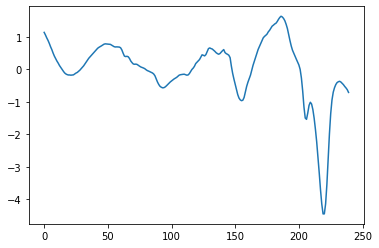

In [14]:
wavelengths = np.arange(0,240,1)
plt.plot(wavelengths, X_unlaballed[2,2,0, :])
plt.show()


Training the ResNet Model

In [ ]:
#RNET_Model= ResNet(in_channel=1,out_channel=1)
#print(RNET_Model)

#Creating the CNN Model		
CNN_Model= ResNetModelDeep().to(device) ###Change to ResNetModel Shallow Where Appropiate
CNN_opt = optim.Adam(CNN_Model.parameters(), lr=5e-4) 

#Training Process Declerations	
criterion_CNN = nn.CrossEntropyLoss()
num_epochs_CNN = 40 
e_losses_array_CNN = np.zeros(num_epochs_CNN)
e_validation_array_CNN = np.zeros(num_epochs_CNN)
train_acc_array_CNN = np.zeros(num_epochs_CNN)
val_acc_array_CNN = np.zeros(num_epochs_CNN)
#scheduler_CNN = optim.lr_scheduler.StepLR(CNN_opt, step_size = 10, gamma=0.1)

#Run each epoch and perform training and validation
for i in range(num_epochs_CNN):
    e_losses_CNN, train_acc = train_epoch(CNN_Model, CNN_opt, criterion_CNN,trainloader_CNN) 
    e_validation_CNN, val_acc = validate_epoch(CNN_Model, CNN_opt, criterion_CNN,valloader_CNN)
    #scheduler_CNN.step()
    
    e_losses_CNN = np.array(e_losses_CNN)
    e_validation_CNN = np.array(e_validation_CNN)
    e_losses_array_CNN[i] = np.average(e_losses_CNN)
    e_validation_array_CNN[i] = np.average(e_validation_CNN)
    train_acc_array_CNN[i] = train_acc
    val_acc_array_CNN[i] = val_acc

##############################################################################	
#Unloading the model off the CUDA
CNN_Model.cpu()

Training the U-NET Model (Was experimental and not documented in report!)

In [ ]:
# #Creating the UNET Neural Network		
# CNN_Model= UNet(in_channel=1,out_channel=1).to(device)
# CNN_opt = optim.Adam(CNN_Model.parameters(), lr=5e-4) 

# #Training Process Declerations	
# criterion_CNN = nn.CrossEntropyLoss()
# num_epochs_CNN =  1 
# e_losses_array_CNN = np.zeros(num_epochs_CNN)
# e_validation_array_CNN = np.zeros(num_epochs_CNN)
# train_acc_array_CNN = np.zeros(num_epochs_CNN)
# val_acc_array_CNN = np.zeros(num_epochs_CNN)
# #scheduler_CNN = optim.lr_scheduler.StepLR(CNN_opt, step_size = 10, gamma=0.1)

# #Run each epoch and perform training and validation
# for i in range(num_epochs_CNN):
#     e_losses_CNN, train_acc = train_epoch(CNN_Model, CNN_opt, criterion_CNN, trainloader_CNN) 
#     e_validation_CNN, val_acc = validate_epoch(CNN_Model, CNN_opt, criterion_CNN, valloader_CNN)
#     #scheduler_CNN.step()
    
#     e_losses_CNN = np.array(e_losses_CNN)
#     e_validation_CNN = np.array(e_validation_CNN)
#     e_losses_array_CNN[i] = np.average(e_losses_CNN)
#     e_validation_array_CNN[i] = np.average(e_validation_CNN)
#     train_acc_array_CNN[i] = train_acc
#     val_acc_array_CNN[i] = val_acc

# ##############################################################################	
# #Unloading the model off the CUDA
# CNN_Model.cpu()

Training the MLP Model

In [ ]:
#Creating the MLP Neural Network		
MLP_Model= MLP().to(device)
MLP_opt = optim.Adam(MLP_Model.parameters(), lr=0.001, weight_decay=0.001) 

#Training Process Declerations	
criterion_MLP = nn.CrossEntropyLoss()
e_losses_MLP = [] 
e_validation_MLP = [] 
num_epochs_MLP =  100
e_losses_array_MLP = np.zeros(num_epochs_MLP)
e_validation_array_MLP = np.zeros(num_epochs_MLP)
#scheduler_MLP = optim.lr_scheduler.StepLR(MLP_opt, step_size = 25, gamma=0.1)

#Run each epoch for training and validation
for i in range(num_epochs_MLP):
    e_losses_MLP, train_acc = train_epoch(MLP_Model, MLP_opt, criterion_MLP, trainloader_MLP) 
    e_validation_MLP, val_acc = validate_epoch(MLP_Model, MLP_opt, criterion_MLP, valloader_MLP)
    #scheduler_MLP.step()
    print(i)
    
    e_losses_MLP = np.array(e_losses_MLP)
    e_validation_MLP = np.array(e_validation_MLP)
    e_losses_array_MLP[i] = np.average(e_losses_MLP)
    e_validation_array_MLP[i] = np.average(e_validation_MLP)
    e_losses_MLP = []
    e_validation_MLP = []

##############################################################################	
#Unloading the model off the CUDA
MLP_Model.cpu()

Testing the CNN Model

In [23]:
############################ Testing Stage ###################################

#This is to control the encoding/decoding
Label_Name = np.zeros((1,1))
Label_Name = Label_Name.astype(int)

Test_Name = np.zeros((1,1))
Test_Name = Test_Name.astype(int)

#This code line is to control formatting
Format = 1

#JPL_Data#############################
JPL_Check = CNN_Model(x_JPL_CNN)
JPL_Check = JPL_Check.detach().numpy()
JPL_Check = np.squeeze(JPL_Check)
JPL_Check = np.argmax(JPL_Check, axis = 1)

print(" ")
print("~~~~JPL STARTS HERE~~~~~~")

for i in range(y_JPL_CNN.shape[0]):
    JPL_Check_Array[y_JPL_CNN[i], JPL_Check[i]] = JPL_Check_Array[y_JPL_CNN[i], JPL_Check[i]] + 1
    JPL_Check_Array = JPL_Check_Array.astype(int)

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is JPL Test Label", Label_Val)
    for j in range (30):
            if JPL_Check_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, JPL_Check_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~JPL ENDS HERE~~~~~~")
print(" ")
######################################

#USGS_Data############################
USGS_Check = CNN_Model(x_USGS_CNN)
USGS_Check = USGS_Check.detach().numpy()
USGS_Check = np.squeeze(USGS_Check)
USGS_Check = np.argmax(USGS_Check, axis = 1)

print("~~~~USGS STARTS HERE~~~~~~")

for i in range(y_USGS_CNN.shape[0]):
    print(y_USGS_CNN[i])
    print(USGS_Check[i])
    USGS_Check_Array[y_USGS_CNN[i], USGS_Check[i]] = USGS_Check_Array[y_USGS_CNN[i], USGS_Check[i]] + 1
    USGS_Check_Array = USGS_Check_Array.astype(int)

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is USGS Test Label", Label_Val)
    for j in range (30):
            if USGS_Check_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, USGS_Check_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~USGS ENDS HERE~~~~~~")
print(" ")  
######################################


#CSIRO Data###########################
CSIRO_Check = CNN_Model(x_CSIRO_CNN)
CSIRO_Check = CSIRO_Check.detach().numpy()
CSIRO_Check = np.squeeze(CSIRO_Check)
CSIRO_Check = np.argmax(CSIRO_Check, axis = 1)

print("~~~~CSIRO STARTS HERE~~~~~~")

for i in range(y_CSIRO_CNN.shape[0]):
    print(y_CSIRO_CNN[i])
    print(CSIRO_Check[i])
    CSIRO_Check_Array[y_CSIRO_CNN[i], CSIRO_Check[i]] = CSIRO_Check_Array[y_CSIRO_CNN[i], CSIRO_Check[i]] + 1
    CSIRO_Check_Array = CSIRO_Check_Array.astype(int)
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is CSIRO Test Label", Label_Val)
    for j in range (30):
            if CSIRO_Check_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, CSIRO_Check_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~CSIRO ENDS HERE~~~~~~")
print(" ")  
#######################################


#BU Data###########################
BU_Check = CNN_Model(x_BU_CNN)
BU_Check = BU_Check.detach().numpy()
BU_Check = np.squeeze(BU_Check)
BU_Check = np.argmax(BU_Check, axis = 1)

print("~~~~BU STARTS HERE~~~~~~")

for i in range(y_BU_CNN.shape[0]):
    BU_Check_Array[y_BU_CNN[i], BU_Check[i]] = BU_Check_Array[y_BU_CNN[i], BU_Check[i]] + 1
    BU_Check_Array = BU_Check_Array.astype(int)
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if BU_Check_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, BU_Check_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~BU ENDS HERE~~~~~~")
print(" ")

# ALL DATA
Total_Array = USGS_Check_Array + CSIRO_Check_Array + JPL_Check_Array + BU_Check_Array

print("~~~~ALL STARTS HERE~~~~~~")
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if Total_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, Total_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~ALL ENDS HERE~~~~~~")
print(" ")
#######################################

 
~~~~JPL STARTS HERE~~~~~~
This is JPL Test Label [b'Actinolite']
[b'Actinolite'] 2 [b'Chlorite'] 4  
This is JPL Test Label [b'Albite']
[b'Andalusite'] 1 [b'Biotite'] 5  
This is JPL Test Label [b'Andalusite']
This is JPL Test Label [b'Anhydrite']
[b'Anhydrite'] 5 [b'Halloysite'] 1  
This is JPL Test Label [b'Apatite']
[b'Albite'] 1 [b'Apatite'] 3 [b'Orthoclase'] 1 [b'Quartz'] 1  
This is JPL Test Label [b'Arsenopyrite']
[b'Biotite'] 1 [b'Hematite'] 2 [b'Muscovite'] 1 [b'Pyrite'] 2  
This is JPL Test Label [b'Biotite']
[b'Biotite'] 6  
This is JPL Test Label [b'Calcite']
[b'Andalusite'] 1 [b'Anhydrite'] 1 [b'Biotite'] 3 [b'Calcite'] 11 [b'Chalcopyrite'] 1 [b'Orthoclase'] 1  
This is JPL Test Label [b'Chalcopyrite']
[b'Albite'] 1 [b'Chalcopyrite'] 2 [b'Hematite'] 3  
This is JPL Test Label [b'Chlorite']
[b'Biotite'] 2 [b'Chlorite'] 16  
This is JPL Test Label [b'Dolomite']
[b'Anhydrite'] 1 [b'Dolomite'] 9 [b'Rutile'] 2  
This is JPL Test Label [b'Epidote']
[b'Biotite'] 2 [b'Epidote'] 

The Below Code was Adopted for the Window Slicing Technique which showed little progress, hence is unusable and commented out!

In [ ]:
# ############################ Testing Stage ###################################
# #Plotting
# epoch = np.arange(1, num_epochs_CNN + 1, 1)
# plt.plot(epoch, e_losses_array_CNN, 'bo--', label = "training loss")  
# plt.plot(epoch, e_validation_array_CNN, 'r+--', label = "validation loss")     
# plt.legend(loc="upper right")
# plt.xlabel('Epochs', fontsize=14, fontweight='bold')
# plt.ylabel('Loss', fontsize=14, fontweight='bold')
# plt.show()

# #Plotting of the accruacy
# plt.plot(epoch, train_acc_array_CNN, 'b-', label = "training acc")  
# plt.plot(epoch, val_acc_array_CNN, 'r-', label = "validation acc")     
# plt.legend(loc="best")
# plt.xlabel('Epochs', fontsize=14, fontweight='bold')
# plt.ylabel('Accuracy',fontsize=14, fontweight='bold')
# plt.show()

# #This is to control the encoding/decoding
# Label_Name = np.zeros((1,1))
# Label_Name = Label_Name.astype(int)

# Test_Name = np.zeros((1,1))
# Test_Name = Test_Name.astype(int)

# #This code line is to control formatting
# Format = 1

# JPL_Check = TestDataSplit(x_JPL_CNN, CNN_Model)

# print(JPL_Check)
# print(" ")
# print("~~~~JPL STARTS HERE~~~~~~")

# for i in range(y_JPL_CNN.shape[0]):
#     JPL_Check_Array[y_JPL_CNN[i], JPL_Check[i]] = JPL_Check_Array[y_JPL_CNN[i], JPL_Check[i]] + 1
#     JPL_Check_Array = JPL_Check_Array.astype(int)

# for i in range (30):
#     Label_Name[0, 0] = i
#     Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
#     print("This is JPL Test Label", Label_Val)
#     for j in range (30):
#             if JPL_Check_Array[i,j] > 0:
#                 Test_Name[0, 0] = j
#                 Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
#                 print(Test_Val, JPL_Check_Array[i,j], end = " ")
#                 Format = 0
#     if (Format == 0):
#         print(" ")
#         Format = 1
# print("~~~~JPL ENDS HERE~~~~~~")
# print(" ")
# ######################################

# USGS_Check = TestDataSplit(x_USGS_CNN, CNN_Model)

# print("~~~~USGS STARTS HERE~~~~~~")

# for i in range(y_USGS_CNN.shape[0]):
#     USGS_Check_Array[y_USGS_CNN[i], USGS_Check[i]] = USGS_Check_Array[y_USGS_CNN[i], USGS_Check[i]] + 1
#     USGS_Check_Array = USGS_Check_Array.astype(int)

# for i in range (30):
#     Label_Name[0, 0] = i
#     Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
#     print("This is USGS Test Label", Label_Val)
#     for j in range (30):
#             if USGS_Check_Array[i,j] > 0:
#                 Test_Name[0, 0] = j
#                 Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
#                 print(Test_Val, USGS_Check_Array[i,j], end = " ")
#                 Format = 0
#     if (Format == 0):
#         print(" ")
#         Format = 1
# print("~~~~USGS ENDS HERE~~~~~~")
# print(" ")  
# ######################################

# CSIRO_Check = TestDataSplit(x_CSIRO_CNN, CNN_Model)

# print("~~~~CSIRO STARTS HERE~~~~~~")

# for i in range(y_CSIRO_CNN.shape[0]):
#     CSIRO_Check_Array[y_CSIRO_CNN[i], CSIRO_Check[i]] = CSIRO_Check_Array[y_CSIRO_CNN[i], CSIRO_Check[i]] + 1
#     CSIRO_Check_Array = CSIRO_Check_Array.astype(int)
    
# for i in range (30):
#     Label_Name[0, 0] = i
#     Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
#     print("This is CSIRO Test Label", Label_Val)
#     for j in range (30):
#             if CSIRO_Check_Array[i,j] > 0:
#                 Test_Name[0, 0] = j
#                 Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
#                 print(Test_Val, CSIRO_Check_Array[i,j], end = " ")
#                 Format = 0
#     if (Format == 0):
#         print(" ")
#         Format = 1
# print("~~~~CSIRO ENDS HERE~~~~~~")
# print(" ")  
# #######################################

# BU_Check = TestDataSplit(x_BU_CNN, CNN_Model)

# print("~~~~BU STARTS HERE~~~~~~")

# for i in range(y_BU_CNN.shape[0]):
#     BU_Check_Array[y_BU_CNN[i], BU_Check[i]] = BU_Check_Array[y_BU_CNN[i], BU_Check[i]] + 1
#     BU_Check_Array = BU_Check_Array.astype(int)
    
# for i in range (30):
#     Label_Name[0, 0] = i
#     Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
#     print("This is BU Test Label", Label_Val)
#     for j in range (30):
#             if BU_Check_Array[i,j] > 0:
#                 Test_Name[0, 0] = j
#                 Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
#                 print(Test_Val, BU_Check_Array[i,j], end = " ")
#                 Format = 0
#     if (Format == 0):
#         print(" ")
#         Format = 1
# print("~~~~BU ENDS HERE~~~~~~")
# print(" ")

# # ALL DATA
# Total_Array = USGS_Check_Array + CSIRO_Check_Array + JPL_Check_Array + BU_Check_Array

# print("~~~~ALL STARTS HERE~~~~~~")
    
# for i in range (30):
#     Label_Name[0, 0] = i
#     Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
#     print("This is BU Test Label", Label_Val)
#     for j in range (30):
#             if Total_Array[i,j] > 0:
#                 Test_Name[0, 0] = j
#                 Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
#                 print(Test_Val, Total_Array[i,j], end = " ")
#                 Format = 0
#     if (Format == 0):
#         print(" ")
#         Format = 1
# print("~~~~ALL ENDS HERE~~~~~~")
# print(" ")
# #######################################

Plotting the CNN Loss/Accruarcy

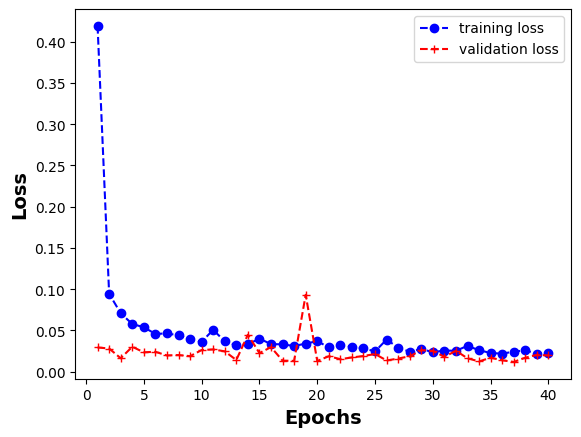

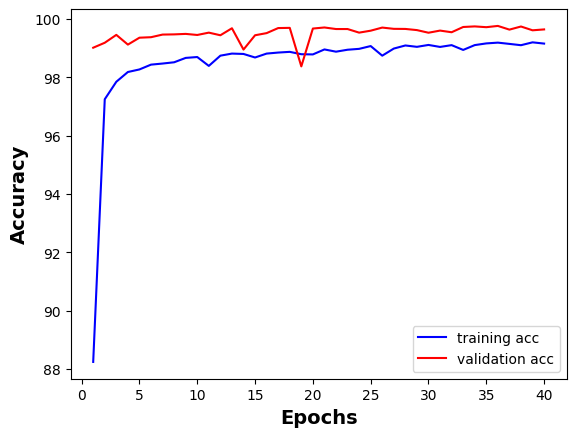

In [15]:
#Plotting the CNN Loss/Accrurarcy Values

plt.style.use('default')
epoch = np.arange(1, num_epochs_CNN + 1, 1)
plt.plot(epoch, e_losses_array_CNN, 'bo--', label = "training loss")  
plt.plot(epoch, e_validation_array_CNN, 'r+--', label = "validation loss")     
plt.legend(loc="upper right")
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.show()

#Plotting of the accruacy
plt.plot(epoch, train_acc_array_CNN, 'b-', label = "training acc")  
plt.plot(epoch, val_acc_array_CNN, 'r-', label = "validation acc")     
plt.legend(loc="best")
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy',fontsize=14, fontweight='bold')
plt.show()

Obtaining the CNN Test Accruarcy.

In [16]:
test_acc = test_epoch(CNN_Model,testloader_CNN)
print(test_acc)

99.8


Testing the MLP Model: (Note includes Test results, test accruarcy and plotting)

 
~~~~JPL STARTS HERE~~~~~~
This is JPL Test Label [b'Actinolite']
[b'Actinolite'] 6  
This is JPL Test Label [b'Albite']
[b'Hornblende'] 1 [b'Kaolinite'] 4 [b'Muscovite'] 1  
This is JPL Test Label [b'Andalusite']
This is JPL Test Label [b'Anhydrite']
[b'Anhydrite'] 1 [b'Halloysite'] 2 [b'Orthoclase'] 3  
This is JPL Test Label [b'Apatite']
[b'Anhydrite'] 1 [b'Apatite'] 2 [b'Dolomite'] 3  
This is JPL Test Label [b'Arsenopyrite']
[b'Arsenopyrite'] 1 [b'Biotite'] 1 [b'Chalcopyrite'] 3 [b'Pyrite'] 1  
This is JPL Test Label [b'Biotite']
[b'Biotite'] 6  
This is JPL Test Label [b'Calcite']
[b'Calcite'] 18  
This is JPL Test Label [b'Chalcopyrite']
[b'Albite'] 1 [b'Arsenopyrite'] 1 [b'Chalcopyrite'] 4  
This is JPL Test Label [b'Chlorite']
[b'Chlorite'] 12 [b'Phlogopite'] 6  
This is JPL Test Label [b'Dolomite']
[b'Anhydrite'] 4 [b'Dolomite'] 7 [b'Rutile'] 1  
This is JPL Test Label [b'Epidote']
[b'Chlorite'] 4 [b'Epidote'] 8  
This is JPL Test Label [b'Gypsum']
[b'Gypsum'] 6  
This is JP

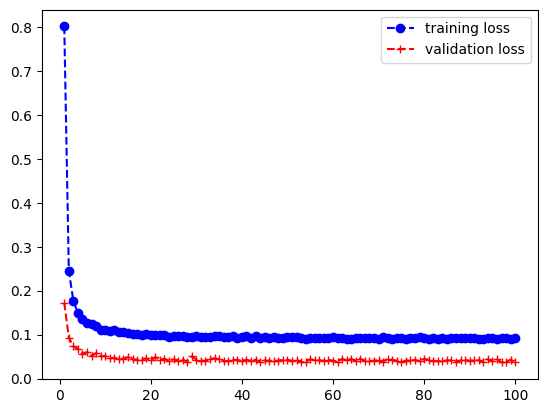

98.8


In [17]:
############################ Testing Stage ###################################

#This is to control the encoding/decoding
Label_Name = np.zeros((1,1))
Label_Name = Label_Name.astype(int)

Test_Name = np.zeros((1,1))
Test_Name = Test_Name.astype(int)

#This code line is to control formatting
Format = 1

#JPL_Data#############################
JPL_Check = MLP_Model(x_JPL_MLP)
JPL_Check = JPL_Check.detach().numpy()
JPL_Check = np.squeeze(JPL_Check)
JPL_Check = np.argmax(JPL_Check, axis = 1)
y_JPL_MLP = y_JPL_MLP.detach().numpy()
y_JPL_MLP = np.squeeze(y_JPL_MLP)
y_JPL_MLP = y_JPL_MLP.astype(int)

print(" ")
print("~~~~JPL STARTS HERE~~~~~~")

for i in range(y_JPL_MLP.shape[0]):
    JPL_Check_Array_MLP[y_JPL_MLP[i], JPL_Check[i]] = JPL_Check_Array_MLP[y_JPL_MLP[i], JPL_Check[i]] + 1
    JPL_Check_Array_MLP = JPL_Check_Array_MLP.astype(int)

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is JPL Test Label", Label_Val)
    for j in range (30):
            if JPL_Check_Array_MLP[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, JPL_Check_Array_MLP[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~JPL ENDS HERE~~~~~~")
print(" ")
######################################

#USGS_Data############################
USGS_Check = MLP_Model(x_USGS_MLP)
USGS_Check = USGS_Check.detach().numpy()
USGS_Check = np.squeeze(USGS_Check)
USGS_Check = np.argmax(USGS_Check, axis = 1)
y_USGS_MLP = y_USGS_MLP.detach().numpy()
y_USGS_MLP = np.squeeze(y_USGS_MLP)
y_USGS_MLP = y_USGS_MLP.astype(int)

print("~~~~USGS STARTS HERE~~~~~~")

for i in range(y_USGS_MLP.shape[0]):
    USGS_Check_Array_MLP[y_USGS_MLP[i], USGS_Check[i]] = USGS_Check_Array_MLP[y_USGS_MLP[i], USGS_Check[i]] + 1
    USGS_Check_Array_MLP = USGS_Check_Array_MLP.astype(int)

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is USGS Test Label", Label_Val)
    for j in range (30):
            if USGS_Check_Array_MLP[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, USGS_Check_Array_MLP[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~USGS ENDS HERE~~~~~~")
print(" ")  
######################################


#CSIRO Data###########################
CSIRO_Check = MLP_Model(x_CSIRO_MLP)
CSIRO_Check = CSIRO_Check.detach().numpy()
CSIRO_Check = np.squeeze(CSIRO_Check)
CSIRO_Check = np.argmax(CSIRO_Check, axis = 1)
y_CSIRO_MLP = y_CSIRO_MLP.detach().numpy()
y_CSIRO_MLP = np.squeeze(y_CSIRO_MLP)
y_CSIRO_MLP = y_CSIRO_MLP.astype(int)

print("~~~~CSIRO STARTS HERE~~~~~~")

for i in range(y_CSIRO_MLP.shape[0]):
    CSIRO_Check_Array_MLP[y_CSIRO_MLP[i], CSIRO_Check[i]] = CSIRO_Check_Array_MLP[y_CSIRO_MLP[i], CSIRO_Check[i]] + 1
    CSIRO_Check_Array_MLP = CSIRO_Check_Array_MLP.astype(int)
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is CSIRO Test Label", Label_Val)
    for j in range (30):
            if CSIRO_Check_Array_MLP[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, CSIRO_Check_Array_MLP[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~CSIRO ENDS HERE~~~~~~")
print(" ")  
#######################################


#BU Data###########################
BU_Check = MLP_Model(x_BU_MLP)
BU_Check = BU_Check.detach().numpy()
BU_Check = np.squeeze(BU_Check)
BU_Check = np.argmax(BU_Check, axis = 1)
y_BU_MLP = y_BU_MLP.detach().numpy()
y_BU_MLP = np.squeeze(y_BU_MLP)
y_BU_MLP = y_BU_MLP.astype(int)

print("~~~~BU STARTS HERE~~~~~~")

for i in range(y_BU_MLP.shape[0]):
    BU_Check_Array_MLP[y_BU_MLP[i], BU_Check[i]] = BU_Check_Array_MLP[y_BU_MLP[i], BU_Check[i]] + 1
    BU_Check_Array_MLP = BU_Check_Array_MLP.astype(int)
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if BU_Check_Array_MLP[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, BU_Check_Array_MLP[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~BU ENDS HERE~~~~~~")
print(" ")

# ALL DATA
Total_Array = USGS_Check_Array + CSIRO_Check_Array + JPL_Check_Array + BU_Check_Array

print("~~~~ALL STARTS HERE~~~~~~")
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if Total_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, Total_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~ALL ENDS HERE~~~~~~")
print(" ")
######################################


#######################################
#Plotting
epoch = np.arange(1, num_epochs_MLP + 1, 1)
plt.plot(epoch, e_losses_array_MLP, 'bo--', label = "training loss")  # plot x and y using blue circle markers
plt.plot(epoch, e_validation_array_MLP, 'r+--', label = "validation loss")     # ditto, but with red plusses
plt.legend(loc="upper right")
plt.show()

test_acc = test_epoch(MLP_Model,testloader_MLP)
print(test_acc)

Plotting the unlabelled 2D Hyperspectral Data (CNN Model)

[[b'Epidote' b'Epidote' b'Epidote' ... b'Epidote' b'Epidote' b'Epidote']
 [b'Epidote' b'Epidote' b'Epidote' ... b'Arsenopyrite' b'Halloysite'
  b'Halloysite']
 [b'Epidote' b'Epidote' b'Epidote' ... b'Arsenopyrite' b'Arsenopyrite'
  b'Arsenopyrite']
 ...
 [b'Epidote' b'Epidote' b'Andalusite' ... b'Halloysite' b'Halloysite'
  b'Andalusite']
 [b'Epidote' b'Epidote' b'Epidote' ... b'Halloysite' b'Halloysite'
  b'Halloysite']
 [b'Biotite' b'Biotite' b'Epidote' ... b'Kaolinite' b'Andalusite'
  b'Andalusite']]


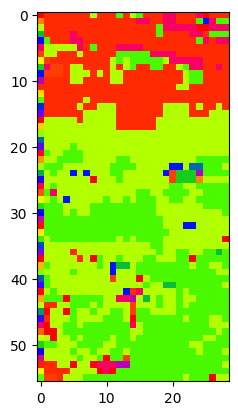

In [24]:
#Declaring Libraries
from scipy.special import softmax
from google.colab import files
import pandas as pd

#Creating Empty Arrays
image_array = []
label_array = []
softmax_array = []
cord_array = []
label_store = []
data_store = []

#Getting the Model Results for each pixel
#Note the softmax array will contain the softmax probability of each pixel (Not included in final report)
for i in range (56):
  NoLabel_Check = CNN_Model(X_unlaballed[i, : , :, :])
  NoLabel_Check = NoLabel_Check.detach().numpy()
  NoLabel_Check = np.squeeze(NoLabel_Check)
  for j in range (28):
    m = softmax(NoLabel_Check[j,:])
    softmax_array.append(m)
  NoLabel_Check = np.argmax(NoLabel_Check, axis = 1)
  Label_Val = Encoded_Labeler.inverse_transform(NoLabel_Check)
  image_array.append(NoLabel_Check)
  label_array.append(Label_Val)

#Converting all arrays into numpy arrays
image_array = np.asarray(image_array)
label_array = np.asarray(label_array)
print(label_array)
softmax_array = np.asarray(softmax_array)
new_softmax_array = np.zeros((56, 28, 30))

#Declaring a counter for the softmax array
counter = 0

#Restoring the 2D Shape for the SoftMax Array
for i in range (56):
  for j in range(28):
    new_softmax_array[i, j, :] = softmax_array[counter, :]
    counter += 1

#Finding the max value
Max_Array = np.amax(new_softmax_array, axis = 2)

for i in range (56):
  for j in range(28):

    if Max_Array[i, j] > 0.95:
      Max_Array[i, j] = 1

    else:
      Max_Array[i, j] = 0
      
#Appending the array
for i in range(56):
  for j in range(28):
    if Max_Array[i, j] == 1:
      my_cord = np.zeros((2))
      my_cord[0] = i
      my_cord[1] = j
      my_data = X_unlaballed[i, j , :, :]
      my_data = my_data.numpy()
      label_store.append(label_array[i, j])
      data_store.append(my_data)
      cord_array.append(my_cord)

#data_store = data_store.numpy()
data_store = np.asarray(data_store)
data_store = np.squeeze(data_store)
label_store = np.asarray(label_store)
cord_array = np.asarray(cord_array)

#Append label_array with a colour
append_array = np.arange(0,56,1)
append_array = np.expand_dims(append_array, axis = 1)
image_array = np.concatenate( (append_array, image_array), axis = 1)

plt.imshow(image_array, cmap = 'prism')
plt.show()
#plt.imshow(Max_Array, cmap = 'binary') #THe black pixels in this will have the softmax values that are higher than 0.95
#plt.show()

Plotting the unlabelled 2D Hyperspectral Data (SAM)

[[b'Calcite' b'Calcite' b'Calcite' ... b'Anhydrite' b'Anhydrite'
  b'Anhydrite']
 [b'Calcite' b'Calcite' b'Calcite' ... b'Anhydrite' b'Gypsum' b'Gypsum']
 [b'Epidote' b'Calcite' b'Epidote' ... b'Gypsum' b'Gypsum' b'Gypsum']
 ...
 [b'Talc' b'Talc' b'Talc' ... b'Halloysite' b'Halloysite' b'Halloysite']
 [b'Phlogopite' b'Phlogopite' b'Phlogopite' ... b'Gypsum' b'Halloysite'
  b'Gypsum']
 [b'Tourmaline' b'Phlogopite' b'Phlogopite' ... b'Halloysite'
  b'Halloysite' b'Kaolinite']]


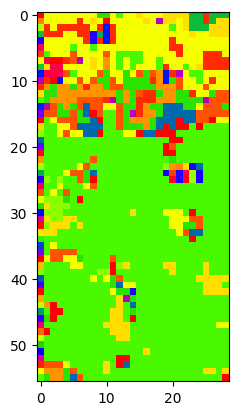

In [25]:
###Doing the SAM Labelling

#Import Libraries
from scipy.special import softmax
from google.colab import files
import pandas as pd

Distance_Array = []
result_array = []
K = 1
K_Array = []

image_array = []
label_array = []
softmax_array = []
cord_array = []

label_store = []
data_store = []

Label_array_store = []

for i in range (56):
  for j in range(28):
    for k in range(x_ED_ref.shape[0]):
        Distance_Array_top = np.multiply(x_ED_ref[k, 3:243], X_unlabelled_notensor[i, j, :, :]) 
        Distance_Array_top = np.sum(Distance_Array_top)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(X_unlabelled_notensor[i, j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    for a in range(K):
        K_Array.append(y_ED_ref[sort_index[a]][0])

    NoLabel_Check = max(set(K_Array), key=K_Array.count)
    Label_array_store.append(NoLabel_Check)
    K_Array = []
    Distance_Array = []

  NoLabel_Check = np.asarray(Label_array_store)  
  Label_Val = Encoded_Labeler.inverse_transform(NoLabel_Check)
  image_array.append(NoLabel_Check)
  label_array.append(Label_Val)
  Label_array_store = []

image_array = np.asarray(image_array)
label_array = np.asarray(label_array)
print(label_array)

#Append label_array with a colour
append_array = np.arange(0,56,1)
append_array = np.expand_dims(append_array, axis = 1)
image_array = np.concatenate( (append_array, image_array), axis = 1)

plt.imshow(image_array, cmap = 'prism')
plt.show()

Getting NCVL Code Result Data for the CNN Model

In [20]:
#i##Code here to sort the algorithim
Encoded_Labeler_New = Define_LabelEncoder(x_NCVL_label) #Only need to define once
x_NCVL_label = Encoded_Labeler_New.transform(x_NCVL_label)

result_array = []

for i in range (x_NCVL_label.shape[0]): #x_NCVL_label.shape[0]
    input_result = x_NCVL_source[i, :, :]
    input_result = input_result.unsqueeze(0)
    result_store = CNN_Model(input_result)
    result_store = result_store.detach().numpy()
    result_store = np.squeeze(result_store)
    result_store = np.argmax(result_store, axis = 0)
    result_array.append(result_store)

NCVL_Check = np.asarray(result_array)

NCVL_Check_Array = np.zeros((30, 30))

print(" ")
print("~~~~NCVL STARTS HERE~~~~~~")

for i in range(x_NCVL_label.shape[0]):
    NCVL_Check_Array[x_NCVL_label[i], NCVL_Check[i]] = NCVL_Check_Array[x_NCVL_label[i], NCVL_Check[i]] + 1
    NCVL_Check_Array = NCVL_Check_Array.astype(int)

for i in range (7):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler_New.inverse_transform(Label_Name[0, :])
    print("This is JPL Test Label", Label_Val)
    for j in range (30):
            if NCVL_Check_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, NCVL_Check_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~NCVL ENDS HERE~~~~~~")
print(" ")

 
~~~~NCVL STARTS HERE~~~~~~
This is JPL Test Label ['CARBONATE']
[b'Actinolite'] 9 [b'Albite'] 4 [b'Andalusite'] 42 [b'Anhydrite'] 1 [b'Biotite'] 10 [b'Calcite'] 24 [b'Chalcopyrite'] 1 [b'Chlorite'] 6 [b'Dolomite'] 1 [b'Epidote'] 31 [b'Halloysite'] 12 [b'Hornblende'] 1 [b'Orthoclase'] 2 [b'Phlogopite'] 1  
This is JPL Test Label ['CHLORITE']
[b'Actinolite'] 29 [b'Albite'] 20 [b'Andalusite'] 5026 [b'Biotite'] 68 [b'Calcite'] 5 [b'Chlorite'] 64 [b'Epidote'] 5689 [b'Halloysite'] 42 [b'Hornblende'] 14 [b'Kaolinite'] 1 [b'Montmorillonite'] 1 [b'Orthoclase'] 10 [b'Phlogopite'] 63 [b'Quartz'] 2  
This is JPL Test Label ['DARK-MICA']
[b'Actinolite'] 1 [b'Andalusite'] 31 [b'Biotite'] 2 [b'Epidote'] 16 [b'Kaolinite'] 1 [b'Phlogopite'] 8  
This is JPL Test Label ['EPIDOTE']
[b'Actinolite'] 8 [b'Andalusite'] 118 [b'Biotite'] 9 [b'Epidote'] 125 [b'Halloysite'] 6 [b'Hornblende'] 1 [b'Kaolinite'] 4 [b'Phlogopite'] 18  
This is JPL Test Label ['KAOLIN']
[b'Actinolite'] 3 [b'Albite'] 6 [b'Andalusite']

Getting NCVL Code Result Data for the SAM Model

In [21]:
## Code to Process the NVCL Data under the SAM
Encoded_Labeler_New = Define_LabelEncoder(x_NCVL_label) #Only need to define once
x_NCVL_label = Encoded_Labeler_New.transform(x_NCVL_label)

Distance_Array = []
result_array = []
K = 1
K_Array = []

for j in range (x_NVCL_SAM.shape[0]):
    ###ED Application#####
    #Distance_Array = np.sqrt(np.square(x_ED_ref - x_NVCL_SAM[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    for k in range(x_ED_ref.shape[0]):
        print(k)
        Distance_Array_top = np.multiply(x_ED_ref[k, :], x_NVCL_SAM[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_NVCL_SAM[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    for i in range(K):
        K_Array.append(y_ED_ref[sort_index[i]][0])

    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    Train_Check_Array_ED[x_NCVL_label[j], Most_Frequent_Value] = Train_Check_Array_ED[x_NCVL_label[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

print(" ")
print("~~~~NCVL STARTS HERE~~~~~~")

for i in range (7):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler_New.inverse_transform(Label_Name[0, :])
    print("This is NVCL Test Label", Label_Val)
    for j in range (30):
            if Train_Check_Array_ED[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, Train_Check_Array_ED[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~NVCL ENDS HERE~~~~~~")
print(" ")

Streaming output truncated to the last 5000 lines.
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
2

Nearest Neighbour Implimentation (No Training Required)

In [25]:
#Setting the K value for KNN
K = 5

##Arrays to store K Largest values and all distance arrays
K_Array = []
Distance_Array = []

##Merging All the Datasets together for easier outputting of results
All_data = np.concatenate((x_USGS_source, x_CSIRO_source, x_JPL_source, x_BU_source) , axis=0)
All_label = np.concatenate((y_USGS_source, y_CSIRO_source, y_JPL_source, y_BU_source) , axis=0)

#USGS
for j in range (x_USGS_source.shape[0]):

    #ED Implimentation
    ##Note needs to be inside the for loop bar the "sort_index", follows the same structure as the SAM
    #Distance_Array = np.sqrt(np.square(x_train_source - x_USGS_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ## SAM Implimentation
    for k in range(x_train_source.shape[0]):
        #Calculating SAM Distance for each entry
        Distance_Array_top = np.multiply(x_train_source[k, :], x_USGS_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_train_source[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_USGS_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)
    sort_index = np.argsort(Distance_Array)

    #Obtaining the K Largest Values
    for i in range(K):
        K_Array.append(y_train_source[sort_index[i]][0])

    #Assigning the most frequent value and adding it to the confusion matrix
    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    USGS_Check_Array_NN[y_USGS_source[j], Most_Frequent_Value] = USGS_Check_Array_NN[y_USGS_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

print("USGS DONE")

#CSIRO
for j in range (x_CSIRO_source.shape[0]):

    #ED Implimentation
    ##Note needs to be inside the for loop bar the "sort_index", follows the same structure as the SAM
    #Distance_Array = np.sqrt(np.square(x_train_source - x_CSIRO_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ## SAM Implimentation
    for k in range(x_train_source.shape[0]):
        #Calculating SAM Distance for each entry
        Distance_Array_top = np.multiply(x_train_source[k, :], x_CSIRO_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_train_source[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_CSIRO_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    #Obtaining the K Largest Values
    for i in range(K):
        K_Array.append(y_train_source[sort_index[i]][0])

    #Assigning the most frequent value and adding it to the confusion matrix
    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    CSIRO_Check_Array_NN[y_CSIRO_source[j], Most_Frequent_Value] = CSIRO_Check_Array_NN[y_CSIRO_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

#JPL
for j in range (x_JPL_source.shape[0]):

    #ED Implimentation
    ##Note needs to be inside the for loop bar the "sort_index", follows the same structure as the SAM
    #Distance_Array = np.sqrt(np.square(x_train_source - x_JPL_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ## SAM Implimentation
    for k in range(x_train_source.shape[0]):
        #Calculating SAM Distance for each entry
        Distance_Array_top = np.multiply(x_train_source[k, :], x_JPL_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_train_source[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_JPL_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    #Obtaining the K Largest Values
    for i in range(K):
        K_Array.append(y_train_source[sort_index[i]][0])

    #Assigning the most frequent value and adding it to the confusion matrix
    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    JPL_Check_Array_NN[y_JPL_source[j], Most_Frequent_Value] = JPL_Check_Array_NN[y_JPL_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

#BU
for j in range (x_BU_source.shape[0]):

    #ED Implimentation
    ##Note needs to be inside the for loop bar the "sort_index", follows the same structure as the SAM
    #Distance_Array = np.sqrt(np.square(x_train_source - x_BU_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ## SAM Implimentation
    for k in range(x_train_source.shape[0]):
        #Calculating SAM Distance for each entry
        Distance_Array_top = np.multiply(x_train_source[k, :], x_BU_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_train_source[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_BU_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    #Obtaining the K Largest Values
    for i in range(K):
        K_Array.append(y_train_source[sort_index[i]][0])

    #Assigning the most frequent value and adding it to the confusion matrix
    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    BU_Check_Array_NN[y_BU_source[j], Most_Frequent_Value] = BU_Check_Array_NN[y_BU_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

# ALL DATA, for easiest printing of results
Total_Array = USGS_Check_Array_NN + CSIRO_Check_Array_NN + JPL_Check_Array_NN + BU_Check_Array_NN


####Printing of Results##############

#JPL_Data#############################
print(" ")
print("~~~~JPL STARTS HERE~~~~~~")

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is JPL Test Label", Label_Val)
    for j in range (30):
            if JPL_Check_Array_NN[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, JPL_Check_Array_NN[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~JPL ENDS HERE~~~~~~")
print(" ")
######################################

#USGS_Data############################
print("~~~~USGS STARTS HERE~~~~~~")

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is USGS Test Label", Label_Val)
    for j in range (30):
            if USGS_Check_Array_NN[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, USGS_Check_Array_NN[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~USGS ENDS HERE~~~~~~")
print(" ")  
######################################


#CSIRO Data###########################
print("~~~~CSIRO STARTS HERE~~~~~~")

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is CSIRO Test Label", Label_Val)
    for j in range (30):
            if CSIRO_Check_Array_NN[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, CSIRO_Check_Array_NN[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~CSIRO ENDS HERE~~~~~~")
print(" ")  
#######################################


#BU Data###########################
print("~~~~BU STARTS HERE~~~~~~")
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if BU_Check_Array_NN[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, BU_Check_Array_NN[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~BU ENDS HERE~~~~~~")
print(" ")
#######################################

#ALL DATA##########
print("~~~~ALL STARTS HERE~~~~~~")
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if Total_Array[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, Total_Array[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~ALL ENDS HERE~~~~~~")
print(" ")
###################

USGS DONE
 
~~~~JPL STARTS HERE~~~~~~
This is JPL Test Label [b'Actinolite']
[b'Actinolite'] 6.0  
This is JPL Test Label [b'Albite']
[b'Actinolite'] 1.0 [b'Andalusite'] 1.0 [b'Biotite'] 1.0 [b'Hornblende'] 1.0 [b'Orthoclase'] 2.0  
This is JPL Test Label [b'Andalusite']
This is JPL Test Label [b'Anhydrite']
[b'Anhydrite'] 6.0  
This is JPL Test Label [b'Apatite']
[b'Actinolite'] 1.0 [b'Anhydrite'] 1.0 [b'Apatite'] 4.0  
This is JPL Test Label [b'Arsenopyrite']
[b'Arsenopyrite'] 2.0 [b'Biotite'] 4.0  
This is JPL Test Label [b'Biotite']
[b'Biotite'] 4.0 [b'Hematite'] 2.0  
This is JPL Test Label [b'Calcite']
[b'Calcite'] 17.0 [b'Dolomite'] 1.0  
This is JPL Test Label [b'Chalcopyrite']
[b'Albite'] 1.0 [b'Arsenopyrite'] 1.0 [b'Chalcopyrite'] 4.0  
This is JPL Test Label [b'Chlorite']
[b'Actinolite'] 4.0 [b'Chlorite'] 10.0 [b'Phlogopite'] 4.0  
This is JPL Test Label [b'Dolomite']
[b'Dolomite'] 9.0 [b'Rutile'] 2.0 [b'Talc'] 1.0  
This is JPL Test Label [b'Epidote']
[b'Chlorite'] 1.0 [b'E

Eucidlian Distance and Spectral Angle Mapper

Note: This will take 30 sample spectras (First from USGS and if not available first from JPL) and test against the other spectras.

In [26]:
#Notes for self:
# 1) Need to make the "train" set which will include 1 of each spectra (First USGS or First JPL)
# 2) Need to make a "test" set which will exclude them, and include 10 spectras randomly selected from training
# This set up will be done tomorrow
# Prior Set Up Will be done today

K = 1
K_Array = []
Distance_Array = []

#Creating a concatenate for my arrays:
All_data = np.concatenate((x_USGS_source, x_CSIRO_source, x_JPL_source, x_BU_source) , axis=0)
All_label = np.concatenate((y_USGS_source, y_CSIRO_source, y_JPL_source, y_BU_source) , axis=0)
print(All_data.shape)
print(All_label.shape)

###DOING ALL FIRST####
for j in range (All_data.shape[0]):
    ###ED Application#####
    #Distance_Array = np.sqrt(np.square(x_ED_ref - x_traindata_ED[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    for k in range(x_ED_ref.shape[0]):
        Distance_Array_top = np.multiply(x_ED_ref[k, :], All_data[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(All_data[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    for i in range(K):
        K_Array.append(y_ED_ref[sort_index[i]][0])

    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    Train_Check_Array_ED[All_label[j], Most_Frequent_Value] = Train_Check_Array_ED[All_label[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

#USGS
for j in range (x_USGS_source_ED.shape[0]):
    ###ED Application#####
    #Distance_Array = np.sqrt(np.square(x_ED_ref - x_USGS_source_ED[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1)
    #sort_index = np.argsort(Distance_Array)

    ##SAM Application#####
    for k in range(x_ED_ref.shape[0]):
        Distance_Array_top = np.multiply(x_ED_ref[k, :], x_USGS_source_ED[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_USGS_source_ED[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)
    for i in range(K):
        K_Array.append(y_ED_ref[sort_index[i]][0])

    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    USGS_Check_Array_ED[y_USGS_source_ED[j], Most_Frequent_Value] = USGS_Check_Array_ED[y_USGS_source_ED[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []
#CSIRO
for j in range (x_CSIRO_source.shape[0]):
    ###ED Application#####
    #Distance_Array = np.sqrt(np.square(x_ED_ref - x_CSIRO_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ##SAM Application#####
    for k in range(x_ED_ref.shape[0]):
        Distance_Array_top = np.multiply(x_ED_ref[k, :], x_CSIRO_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_CSIRO_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    for i in range(K):
        K_Array.append(y_ED_ref[sort_index[i]][0])

    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    CSIRO_Check_Array_ED[y_CSIRO_source[j], Most_Frequent_Value] = CSIRO_Check_Array_ED[y_CSIRO_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []
#JPL
for j in range (x_JPL_source.shape[0]):
    ###ED Application#####
    #Distance_Array = np.sqrt(np.square(x_ED_ref - x_JPL_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ##SAM Application#####
    for k in range(x_ED_ref.shape[0]):
        Distance_Array_top = np.multiply(x_ED_ref[k, :], x_JPL_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_JPL_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    for i in range(K):
        K_Array.append(y_ED_ref[sort_index[i]][0])

    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    JPL_Check_Array_ED[y_JPL_source[j], Most_Frequent_Value] = JPL_Check_Array_ED[y_JPL_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []
#BU
for j in range (x_BU_source.shape[0]):
    #Distance_Array = np.sqrt(np.square(x_ED_ref - x_BU_source[j, :]))
    #Distance_Array = np.sum(Distance_Array, axis = 1) 
    #sort_index = np.argsort(Distance_Array)

    ##SAM Application#####
    for k in range(x_ED_ref.shape[0]):
        Distance_Array_top = np.multiply(x_ED_ref[k, :], x_BU_source[j, :]) 
        Distance_Array_top = np.sum(Distance_Array_top, axis = 0)

        Distance_Array_bot1 = np.square(x_ED_ref[k, :])
        Distance_Array_bot1 = np.sum(Distance_Array_bot1, axis = 0)
        Distance_Array_bot1 = np.sqrt(Distance_Array_bot1)

        Distance_Array_bot2 = np.square(x_BU_source[j, :]) 
        Distance_Array_bot2 = np.sum(Distance_Array_bot2, axis = 0)
        Distance_Array_bot2 = np.sqrt(Distance_Array_bot2)

        Distance_Array_val = math.acos(Distance_Array_top/(Distance_Array_bot1*Distance_Array_bot2))
        Distance_Array.append(Distance_Array_val)

    sort_index = np.argsort(Distance_Array)

    for i in range(K):
        K_Array.append(y_ED_ref[sort_index[i]][0])

    Most_Frequent_Value = max(set(K_Array), key=K_Array.count)
    BU_Check_Array_ED[y_BU_source[j], Most_Frequent_Value] = BU_Check_Array_ED[y_BU_source[j], Most_Frequent_Value] + 1
    K_Array = []
    Distance_Array = []

#JPL_Data#############################
print(" ")
print("~~~~JPL STARTS HERE~~~~~~")

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is JPL Test Label", Label_Val)
    for j in range (30):
            if JPL_Check_Array_ED[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, JPL_Check_Array_ED[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~JPL ENDS HERE~~~~~~")
print(" ")
######################################

#USGS_Data############################
print("~~~~USGS STARTS HERE~~~~~~")

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is USGS Test Label", Label_Val)
    for j in range (30):
            if USGS_Check_Array_ED[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, USGS_Check_Array_ED[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~USGS ENDS HERE~~~~~~")
print(" ")  
######################################


#CSIRO Data###########################
print("~~~~CSIRO STARTS HERE~~~~~~")

for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is CSIRO Test Label", Label_Val)
    for j in range (30):
            if CSIRO_Check_Array_ED[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, CSIRO_Check_Array_ED[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~CSIRO ENDS HERE~~~~~~")
print(" ")  
#######################################


#BU Data###########################
print("~~~~BU STARTS HERE~~~~~~")
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if BU_Check_Array_ED[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, BU_Check_Array_ED[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~BU ENDS HERE~~~~~~")
print(" ")
#######################################

#Train Data###########################
print("~~~~ALL STARTS HERE~~~~~~")
    
for i in range (30):
    Label_Name[0, 0] = i
    Label_Val = Encoded_Labeler.inverse_transform(Label_Name[0, :])
    print("This is BU Test Label", Label_Val)
    for j in range (30):
            if Train_Check_Array_ED[i,j] > 0:
                Test_Name[0, 0] = j
                Test_Val = Encoded_Labeler.inverse_transform(Test_Name[0, :])
                print(Test_Val, Train_Check_Array_ED[i,j], end = " ")
                Format = 0
    if (Format == 0):
        print(" ")
        Format = 1
print("~~~~ALL ENDS HERE~~~~~~")
print(" ")
#######################################

(800, 246)
(800, 1)
 
~~~~JPL STARTS HERE~~~~~~
This is JPL Test Label [b'Actinolite']
[b'Actinolite'] 6.0  
This is JPL Test Label [b'Albite']
[b'Albite'] 1.0 [b'Apatite'] 2.0 [b'Chlorite'] 1.0 [b'Muscovite'] 1.0 [b'Phlogopite'] 1.0  
This is JPL Test Label [b'Andalusite']
This is JPL Test Label [b'Anhydrite']
[b'Anhydrite'] 6.0  
This is JPL Test Label [b'Apatite']
[b'Actinolite'] 3.0 [b'Dolomite'] 2.0 [b'Talc'] 1.0  
This is JPL Test Label [b'Arsenopyrite']
[b'Biotite'] 1.0 [b'Gypsum'] 1.0 [b'Olivine'] 2.0 [b'Pyrite'] 1.0 [b'Rutile'] 1.0  
This is JPL Test Label [b'Biotite']
[b'Biotite'] 6.0  
This is JPL Test Label [b'Calcite']
[b'Calcite'] 18.0  
This is JPL Test Label [b'Chalcopyrite']
[b'Chalcopyrite'] 1.0 [b'Hematite'] 2.0 [b'Orthoclase'] 1.0 [b'Quartz'] 1.0 [b'Rutile'] 1.0  
This is JPL Test Label [b'Chlorite']
[b'Chlorite'] 15.0 [b'Hornblende'] 2.0 [b'Phlogopite'] 1.0  
This is JPL Test Label [b'Dolomite']
[b'Calcite'] 6.0 [b'Dolomite'] 6.0  
This is JPL Test Label [b'Epidote